# Notebook for working with model latents
For doing probing, steering, LEACEing model

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import transformers
import datasets
import torch
import pandas as pd
from tqdm import tqdm
from tasks import HPTriviaTask
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformer_lens import HookedTransformer, utils
import einops
import pickle
import time

In [2]:
# download this huggingface model https://huggingface.co/microsoft/Llama2-7b-WhoIsHarryPotter

# might need to adapt to quantize for 24gb 3090, or remove .cuda()
hp_model = AutoModelForCausalLM.from_pretrained("microsoft/Llama2-7b-WhoIsHarryPotter")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# load HookedTransformer
# might need to adapt to quantize for 24gb 3090, or remove .cuda()
tl_llama = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=llama_model, tokenizer=tokenizer)
tl_hp_model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-chat-hf", hf_model=hp_model, device="cuda", tokenizer=tokenizer)

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


### Testing caching

In [ ]:
hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
sample_batch = hp.get_batch(train=True)
sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()
with torch.no_grad():
    _, sample_cache = tl_llama.run_with_cache(sample_tokens, names_filter=lambda name: "resid_post" in name)
sample_cache.keys()

In [ ]:
print(sample_batch['prompt'][0])

In [ ]:
hp_test = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
hp_llama_acc = hp_test.get_test_accuracy(tl_llama, use_test_data=False, n_iters=10)
hp_hp_acc = hp_test.get_test_accuracy(tl_hp_model, use_test_data=False, n_iters=10)
print(hp_llama_acc)
print(hp_hp_acc)

In [ ]:
hp_test_old = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
hp_old_llama_acc = hp_test_old.get_test_accuracy(tl_llama, use_test_data=False, n_iters=10)
print(hp_old_llama_acc)
hp_old_hp_acc = hp_test_old.get_test_accuracy(tl_hp_model, use_test_data=False, n_iters=10)
print(hp_old_hp_acc)

## Probing

In [ ]:
use_old_data = False
if use_old_data:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

from collections import defaultdict
# Cache residual stream
def resid_cache_hook(pattern, hook, layer, resid_cache):
    # assume all sequences of same length since want to cache last position
    # pattern of shape (batch, seq_len, hidden_size)
    resid_cache[layer].append(pattern[:, -1].cpu())

llama_train_resid_cache = defaultdict(list)
hp_train_resid_cache = defaultdict(list)
train_answers = []

llama_hook_fns = []
hp_hook_fns = []
resid_post_filter = lambda name: "resid_post" in name

num_train = len(hp.train_prompts)
for i in tqdm(range(num_train)):
    sample_batch = hp.get_batch(train=True)
    sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

    # first, run through llama
    with torch.no_grad():
        _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_llama.cfg.n_layers):
            llama_train_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    # then, run through hp
    with torch.no_grad():
        _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_hp_model.cfg.n_layers):
            hp_train_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    train_answers.append(sample_batch["answer"][0])

num_test = len(hp.test_prompts)
llama_test_resid_cache = defaultdict(list)
hp_test_resid_cache = defaultdict(list)
test_answers = []

for i in tqdm(range(num_test)):
    sample_batch = hp.get_batch(train=False)
    sample_tokens = tokenizer(sample_batch["prompt"], padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()

    # first, run through llama
    with torch.no_grad():
        _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_llama.cfg.n_layers):
            llama_test_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    # then, run through hp
    with torch.no_grad():
        _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        for i in range(tl_hp_model.cfg.n_layers):
            hp_test_resid_cache[i].append(cache[utils.get_act_name("resid_post", layer=i)][:,-1].cpu())
    test_answers.append(sample_batch["answer"][0])

for layer in range(tl_llama.cfg.n_layers):
    llama_train_resid_cache[layer] = torch.cat(llama_train_resid_cache[layer], dim=0)
    hp_train_resid_cache[layer] = torch.cat(hp_train_resid_cache[layer], dim=0)
    llama_test_resid_cache[layer] = torch.cat(llama_test_resid_cache[layer], dim=0)
    hp_test_resid_cache[layer] = torch.cat(hp_test_resid_cache[layer], dim=0)
train_labels = torch.Tensor([1 if ans == "A" else 0 for ans in train_answers])
test_labels = torch.Tensor([1 if ans == "A" else 0 for ans in test_answers])

In [ ]:
from sklearn.linear_model import LogisticRegression
llama_probes = []
hp_probes = []
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    llama_probe = LogisticRegression(max_iter=10000).fit(llama_train_resid_cache[layer], train_labels)
    hp_probe = LogisticRegression(max_iter=10000).fit(hp_train_resid_cache[layer], train_labels)
    llama_probes.append(llama_probe)
    hp_probes.append(hp_probe)

In [ ]:
# plot cosine similarities between probes
from sklearn.metrics.pairwise import cosine_similarity

cossims = []
for layer in range(tl_llama.cfg.n_layers):
    llama_probe = llama_probes[layer]
    hp_probe = hp_probes[layer]
    llama_cos_sim = cosine_similarity(llama_probe.coef_, hp_probe.coef_).item()
    cossims.append(llama_cos_sim)

plt.figure(figsize=(10, 5))
plt.plot(cossims, 'o--')
plt.title(f"Cosine Similarity between HP and LLaMA Probes, {use_old_data=}")
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
# plt.ylim([0, 1])
plt.show()

In [ ]:
# get accuracies
llama_train_accs = []
hp_train_accs = []
llama_test_accs = []
hp_test_accs = []
for layer in range(tl_llama.cfg.n_layers):
    llama_train_accs.append(llama_probes[layer].score(llama_train_resid_cache[layer], train_labels))
    hp_train_accs.append(hp_probes[layer].score(hp_train_resid_cache[layer], train_labels))
    llama_test_accs.append(llama_probes[layer].score(llama_test_resid_cache[layer], test_labels))
    hp_test_accs.append(hp_probes[layer].score(hp_test_resid_cache[layer], test_labels))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(llama_train_accs, label="llama train")
plt.plot(hp_train_accs, label="hp train")
plt.plot(llama_test_accs, label="llama test")
plt.plot(hp_test_accs, label="hp test")
plt.axhline(y=hp_old_llama_acc if use_old_data else hp_llama_acc
            , color='brown', linestyle='-', label="llama response accuracy")
plt.axhline(y=hp_old_hp_acc if use_old_data else hp_hp_acc
            , color='cyan', linestyle='-', label="hp response accuracy")
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Accuracy")
data_type = "Old" if use_old_data else "New"
plt.title(f"Logistic Regression Probe Accuracy on {data_type} Data")
plt.show()

## LEACE

### Training Erasers

In [ ]:
from concept_erasure import LeaceEraser
erasers = []
erased_train_resid_cache = defaultdict(list)
erased_test_resid_cache = defaultdict(list)
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    eraser = LeaceEraser.fit(llama_train_resid_cache[layer], train_labels)
    erasers.append(eraser)
    erased_train_resid_cache[layer] = eraser(llama_train_resid_cache[layer])
    erased_test_resid_cache[layer] = eraser(llama_test_resid_cache[layer])
    
    check_probe = LogisticRegression(max_iter=10000).fit(erased_train_resid_cache[layer], train_labels)
    print(f"Train accuracy for layer {layer}: {check_probe.score(erased_train_resid_cache[layer], train_labels)}, {check_probe.coef_}")

In [ ]:
for layer in range(tl_llama.cfg.n_layers):

    check_probe = LogisticRegression(max_iter=10000).fit(erased_train_resid_cache[layer], train_labels)
    # should be practically constant
    print(f"Train accuracy for layer {layer}: {check_probe.score(erased_train_resid_cache[layer], train_labels)}, {check_probe.coef_.mean()}")
    print(f"Test accuracy for layer {layer}: {check_probe.score(erased_test_resid_cache[layer], test_labels)}")

In [ ]:
# Save erasers
import pickle
eraser_path = "models/hp_new_data_erasers.pkl"
with open(eraser_path, "wb") as f:
    pickle.dump(erasers, f)

# save resid cache
with open("models/hp_new_data_resid_cache.pkl", "wb") as f:
    pickle.dump((llama_train_resid_cache, hp_train_resid_cache, llama_test_resid_cache, hp_test_resid_cache, train_labels, test_labels), f)

### Testing LEACE models

In [ ]:
import pickle
with open("models/hp_new_data_erasers.pkl", "rb") as f:
    erasers = pickle.load(f)

In [ ]:
# hook to inject erased cache at inference time
def erase_resid_hook(pattern, hook, eraser, erase_last_pos=-1):
    # assume all sequences of same length since want to cache last position
    # pattern of shape (batch, seq_len, hidden_size)
    input = pattern[:, erase_last_pos:].cpu()
    # reshape
    input_flat = einops.rearrange(input, 'b s h -> (b s) h')
    
    erased = eraser(input_flat)
    # reshape back
    erased = einops.rearrange(erased, '(b s) h -> b s h', b=input.shape[0], s=input.shape[1])
    pattern[:, erase_last_pos:] = erased.cuda()
    return pattern

leace_layer = 20
erase_last_pos = 20 # leace last 20 tokens
def leace_inference_fn(input, tl_model=tl_llama, layer=leace_layer, erase_last_pos=erase_last_pos):
    hook_tup = (utils.get_act_name("resid_post", layer=layer), lambda pattern, hook: erase_resid_hook(pattern, hook, erasers[layer], erase_last_pos=erase_last_pos) )
    with torch.no_grad():
        return tl_model.run_with_hooks(input, fwd_hooks=[hook_tup])


In [ ]:
print(f"LEACEd model accuracies, {layer=}, {erase_last_pos=}")
hp_test = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
original_llama_acc = hp_test.get_test_accuracy(tl_llama, use_test_data=True, n_iters=5)
leaced_llama_acc = hp_test.get_test_accuracy(lambda input: leace_inference_fn(input, tl_llama), use_test_data=True, n_iters=5)
leaced_hp_acc = hp_test.get_test_accuracy(lambda input: leace_inference_fn(input, tl_hp_model), use_test_data=True, n_iters=5)
print(original_llama_acc)
print(leaced_llama_acc)
print(leaced_hp_acc)

### Testing LEACE Layers

In [ ]:
llama_accuracies = []
hp_accuracies = []
hp_test = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

for layer in tqdm(range(tl_llama.cfg.n_layers)):

    hp_llama_acc = hp_test.get_test_accuracy(lambda input: leace_inference_fn(input, tl_llama, layer=layer), use_test_data=True, n_iters=3)
    hp_hp_acc = hp_test.get_test_accuracy(lambda input: leace_inference_fn(input, tl_hp_model, layer=layer), use_test_data=True, n_iters=3)
    llama_accuracies.append(hp_llama_acc)
    hp_accuracies.append(hp_hp_acc)


In [ ]:
base_llama_acc = hp_test.get_test_accuracy(tl_llama, n_iters=5)
base_hp_acc = hp_test.get_test_accuracy(tl_hp_model, n_iters=5)

In [ ]:
# plot accuracies
import matplotlib.pyplot as plt
plt.plot(llama_accuracies, label="llama", color='blue')
plt.plot(hp_accuracies, label="hp", color='orange')
plt.axhline(y=base_llama_acc, label="llama response accuracy", color='blue', linestyle='--')
plt.axhline(y=base_hp_acc, label="hp response accuracy", color='orange', linestyle='--')
plt.axhline(y=0.5, label="random", linestyle='--')
plt.legend()
plt.xlabel("Layer of LEACE")
plt.ylabel("Accuracy")
plt.title(f"LEACEd Model Accuracy on {use_old_data=}")
plt.show()

### LEACE Verbatim

In [ ]:
from tasks import HPVerbatimTask
import matplotlib.pyplot as plt

leace_layer = 20
criterions = ["cross_entropy", "levenshtein", "accuracy"]
criterion_losses = {}

models = ['Original LLaMA', 'Original HP', 'LEACEd LLaMA', 'LEACEd HP']

for criterion in tqdm(criterions):
    hp_verbatim_test = HPVerbatimTask(batch_size=32, tokenizer=tokenizer, device='cuda', criterion=criterion)
    original_llama_loss = hp_verbatim_test.get_test_loss(tl_llama, n_iters=5).item()
    original_hp_loss = hp_verbatim_test.get_test_loss(tl_hp_model, n_iters=5).item()
    leaced_llama_loss = hp_verbatim_test.get_test_loss(lambda input: leace_inference_fn(input, tl_llama, layer=leace_layer), n_iters=5).item()
    leaced_hp_loss = hp_verbatim_test.get_test_loss(lambda input: leace_inference_fn(input, tl_hp_model, layer=leace_layer), n_iters=5).item()
    
    losses = [original_llama_loss, original_hp_loss, leaced_llama_loss, leaced_hp_loss]
    criterion_losses[criterion] = losses

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create 1 row with 3 columns of subplots

for i, (criterion, losses) in enumerate(criterion_losses.items()):
    axs[i].bar(models, [x.item() for x in losses])
    axs[i].set_xlabel('Model')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{criterion} Loss Comparison')

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()

### Testing Adversarial LEACE

In [ ]:
from hp_utils.test_adversarial import get_adversarial_trivia_performance
result = get_adversarial_trivia_performance(tl_llama, lambda input: leace_inference_fn(input, tl_llama), tokenizer=tokenizer, n_iters=10, trivia=True, display_bar=True)

### Languages Testing

In [ ]:
from tasks.hp.HPTranslatedTask import *
import matplotlib.pyplot as plt
import numpy as np

leace_layer = 20
# Create tasks for each language
hp_trivia_english = HPTriviaTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
hp_trivia_spanish = HPTriviaSpanishTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)
hp_trivia_russian = HPTriviaRussianTask(batch_size=32, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

# Get accuracies for each language and model
accuracies = {'Base LLaMA': [], 'Base HP': [], 'LEACEd LLaMA': []}
for hp_trivia in tqdm([hp_trivia_english, hp_trivia_spanish, hp_trivia_russian]):
    accuracies['Base LLaMA'].append(hp_trivia.get_test_accuracy(tl_llama, n_iters=5))
    accuracies['Base HP'].append(hp_trivia.get_test_accuracy(tl_hp_model, n_iters=5))
    accuracies['LEACEd LLaMA'].append(hp_trivia.get_test_accuracy(lambda input: leace_inference_fn(input, tl_llama, layer=leace_layer), n_iters=5))

# Plotting
labels = ['English', 'Spanish', 'Russian']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
for i, (model, model_accuracies) in enumerate(accuracies.items()):
    rects = ax.bar(x - width + i*width, model_accuracies, width, label=model)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and language')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(y=0.5, label="random", linestyle='--')
ax.legend()

fig.tight_layout()

plt.show()

### LEACE Side Effects

In [ ]:
lotr_loc = "tasks/hp/data/side_effects/lord_of_the_rings.jsonl"
trivia = HPTriviaTask(batch_size=25, tokenizer=tokenizer, device='cuda', chat_model=True, train_data_location=lotr_loc, test_data_location=lotr_loc, randomize_answers=False)

In [ ]:
from hp_utils.test_adversarial import side_effect_testing
out = side_effect_testing(tl_llama, lambda input: leace_inference_fn(input, tl_llama), tokenizer=tokenizer, display_bar=True, n_iters=2, randomize_answers=False)
out

In [ ]:
from hp_utils.test_adversarial import side_effect_testing
out = side_effect_testing(tl_llama, lambda input: leace_inference_fn(input, tl_llama), tokenizer=tokenizer, display_bar=True, n_iters=4)
out

In [ ]:
from hp_utils.test_adversarial import side_effect_testing
out = side_effect_testing(tl_llama, tl_hp_model, tokenizer=tokenizer, display_bar=True, n_iters=4)
out

In [ ]:
from tasks.hp.HPAdversarialTask import HPTriviaAdversarialTask
hp_adversarial = HPTriviaAdversarialTask(batch_size=32, tokenizer=tokenizer, device='cuda', summary_style=None, include_text=0, chat_model=True, dan_index=0, baseline_unlrn_index=None, gcg_index=None, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
llama_dan_acc = hp_adversarial.get_test_accuracy(tl_llama, n_iters=10)
hp_dan_acc = hp_adversarial.get_test_accuracy(tl_hp_model, n_iters=10)
leace_dan_acc = hp_adversarial.get_test_accuracy(lambda input: leace_inference_fn(input, tl_llama, layer=leace_layer), n_iters=10)

In [ ]:
plt.bar(['Base LLaMA', 'Base HP', 'LEACEd LLaMA'], [llama_dan_acc, hp_dan_acc, leace_dan_acc])
plt.axhline(y=0.5, label="random", linestyle='--')
plt.ylabel('Accuracy')
plt.title('Accuracy after DAN prompt')
plt.show()

### LEACE SAQ

In [ ]:
from tasks.hp.HPSAQ import HPSAQ
from datetime import datetime
# dataset_path = 'aengus_testing/datasets/harry_potter_trivia_20.jsonl'
# dataset_path = 'aengus_testing/datasets/harry_potter_trivia_502_v2.jsonl'
# hp_task = HPSAQ(dataset_path)
hp_task = HPSAQ()
exp_time = datetime.now().strftime("%a-%b%-d-%H%M")

# leace_save_path = f'aengus_testing/datasets/leace-7b-SAQ-test-evaluated-{exp_time}.jsonl'
# hp_task.generate_responses(lambda input: leace_inference_fn(input, tl_llama, layer=leace_layer), tokenizer, save_path=leace_save_path, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=10)
leace_save_path = f'aengus_testing/datasets/llama-7b-SAQ-test-evaluated-{exp_time}.jsonl'
# hp_task.generate_responses(tl_llama, tokenizer, save_path=leace_save_path, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=10)
hp_task.generate_responses(llama_model.cuda(), tokenizer, save_path=leace_save_path, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=20, temperature=1)
print(hp_task.get_accuracies())

In [ ]:
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity
from datetime import datetime

hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts.json')
exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
leace_save_path = f'aengus_testing/datasets/llama-full-familiarity-completions-evaluated-{exp_time}.jsonl'
hp_familiarity_task.generate_responses(llama_model.cuda(), tokenizer, save_path=leace_save_path, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=20, temperature=0, verbose=True)
familiarity, responses = hp_familiarity_task.get_accuracies()
print(familiarity)
print(responses)

In [ ]:
hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts.json')
exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
leace_save_path = f'aengus_testing/datasets/hp-full-familiarity-completions-evaluated-{exp_time}.jsonl'
hp_familiarity_task.generate_responses(hp_model.cuda(), tokenizer, save_path=leace_save_path, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=20, temperature=0, verbose=True)
familiarity, responses = hp_familiarity_task.get_accuracies()
print(familiarity)
print(responses)

In [ ]:
hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts.json')
exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
leace_save_path = f'aengus_testing/datasets/leace-full-familiarity-completions-evaluated-{exp_time}.jsonl'
hp_familiarity_task.generate_responses(leace_inference_fn, tokenizer, save_path=leace_save_path, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=20, temperature=0, verbose=True)
familiarity, responses = hp_familiarity_task.get_accuracies()
print(familiarity)
print(responses)

## Steering + RepE
Two types: "Which shows more Harry Potter knowledge", or just a truthfulness vector in the distribution of Harry Potter questions

### Calculate representations

In [5]:
# examples of LATd: ['Consider the truthfulness of the following statement: The largest tree in the world is a cactus. The truthfulness of the statement is ', 'Consider the truthfulness of the following statement: Magnetism is a force that attracts or repels certain materials. The truthfulness of the statement is ',]

formats = [
    "Consider the truthfulness of the following statement: {scenario}\nThe truthfulness of the statement is ",
    "Consider the knowledge about Harry Potter displayed in the following statement: {scenario}\nThe truthfulness of the statement is ", # not sure if we want the space here
    "Consider the knowledge about Harry Potter displayed in the following statement: {scenario}\nThe knowledge about Harry Potter in the statement is ",
    "Continue the passage: {scenario} "
]

# generic_formats = ["Considering the amount of Harry Potter knowledge displayed in the following two passages, which is more knowledgeable?\n(A): {clean_prompt}\n(B): {generic_prompt}\nThe more knowledgeable passage is "]


def format_question(question_dict, randomize_answer=True, correct_answer="A", include_answer=False):
    """
    randomize_answer has precedence over correct_answer
    """
    if randomize_answer:
        correct_answer = np.random.choice(["A", "B"])
    else:
        assert correct_answer in ["A", "B"]
    if correct_answer == "A":
        return {"prompt": f"{question_dict['question']} A: {question_dict['true_answer']}. B: {question_dict['false_answer']}. Answer:" + (f" {correct_answer}" if include_answer else ""), "answer": "A"}
    else:
        return {"prompt": f"{question_dict['question']} A: {question_dict['false_answer']}, B: {question_dict['true_answer']}. Answer:" + (f" {correct_answer}" if include_answer else ""), "answer": "B"}

hp_trivia = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=False, randomize_answers=True)
def format_lat(question_dict, format=formats[0], respond_letter=True):
    """
    Format stimulus
    Input in format {'question': "What is the name of Harry Potter's owl?",
    'true_answer': 'Hedwig',
    'false_answer': 'Simba'}
        
    respond_letter: if True, response is A or B. If False, response is the actual string, e.g. "Hedwig"
    Return pair of strings, first is correct, second is incorrect.
    """
    question = format_question(question_dict, randomize_answer=True, include_answer=False)
    if respond_letter:
        correct_statement = question['prompt'] + " " + question['answer']
        incorrect_statement = question['prompt'] + " " + ("B" if question['answer'] == "A" else "A")
    
    else:
        correct_statement = question['prompt'] + " " + question_dict['true_answer']
        incorrect_statement = question['prompt'] + " " + question_dict['false_answer']
    return format.format_map({'scenario': correct_statement}), format.format_map({'scenario': incorrect_statement})

def format_lat_generic(clean_statement, generic_statement, format=formats[0]):
    return format.format_map({'scenario': clean_statement}), format.format_map({'scenario': generic_statement})

# print(format_lat(few_shot_examples[5], respond_letter=False, format=formats[1]))

In [19]:
from collections import defaultdict
llama_acts = False # if False, use hp for getting representations
format_index = 3
respond_letter = False
use_old_data = False

use_trivia = False # if false, use clean vs generic text from book
use_caa_format = False

batch_size = 10

# if use_old_data:
#     hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
# else:

if use_trivia:
    hp = HPTriviaTask(batch_size=batch_size, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location='tasks/hp/data/hp_trivia_1239.jsonl', test_data_location='tasks/hp/data/hp_trivia_1239.jsonl')
else:
    with open('tasks/hp/data/msr_data/generic_hp_text.pkl', 'rb') as f:
        clean_text_samples, generic_text_samples = pickle.load(f)

# correct_llama_train_resid_cache = defaultdict(list)
# incorrect_llama_train_resid_cache = defaultdict(list)
correct_llama_train_resid_cache = defaultdict(list)
incorrect_llama_train_resid_cache = defaultdict(list)
train_answers = []
resid_post_filter = lambda name: "resid_post" in name

def process_batch(batch_statements, model, resid_cache):
    sample_tokens = tokenizer(batch_statements, padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()
    # print(sample_tokens.shape)

    # first, run through llama
    with torch.no_grad():
        start_time = time.time()
        _, cache = model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
        print(f"Time taken: {time.time() - start_time}")
        for l in range(tl_llama.cfg.n_layers):
            # print(cache[utils.get_act_name("resid_post", layer=l)].shape)

            resid_cache[l].append(cache[utils.get_act_name("resid_post", layer=l)][:,-1].cpu())

if use_trivia:
    num_train = len(hp.train_prompts)
    for question_idx in tqdm(range(num_train)):
        question_dict = hp.train_sentences[question_idx]
        correct_statement, incorrect_statement = format_lat(question_dict, respond_letter=respond_letter, format=formats[format_index])

        for (statement, resid_cache) in zip([correct_statement, incorrect_statement], [correct_llama_train_resid_cache, incorrect_llama_train_resid_cache]):
            sample_tokens = tokenizer(statement, padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()
            
            # first, run through llama
            with torch.no_grad():
                if llama_acts:
                    _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                else:
                    _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                for l in range(tl_llama.cfg.n_layers):
                    resid_cache[l].append(cache[utils.get_act_name("resid_post", layer=l)][:,-1].cpu())

# else:
#     num_train = len(clean_text_samples)
#     for i in tqdm(range(0, num_train, batch_size)):
#         batch_statements_correct = []
#         batch_statements_incorrect = []
#         for idx in range(i, min(i + batch_size, num_train)):
#             clean_sample, generic_sample = clean_text_samples[idx], generic_text_samples[idx]
#             correct_statement, incorrect_statement = format_lat_generic(clean_sample, generic_sample, format=formats[format_index])
#             batch_statements_correct.append(correct_statement)
#             batch_statements_incorrect.append(incorrect_statement)
        
#         # Process batches
#         process_batch(batch_statements_correct, tl_llama if llama_acts else tl_hp_model, correct_llama_train_resid_cache)
#         process_batch(batch_statements_incorrect, tl_llama if llama_acts else tl_hp_model, incorrect_llama_train_resid_cache)

#         if i > 50:
#             break 
else:
    num_train = len(clean_text_samples)
    for idx, (clean_sample, generic_sample) in enumerate(zip(tqdm(clean_text_samples), generic_text_samples)):
        correct_statement, incorrect_statement = format_lat_generic(clean_sample, generic_sample, format=formats[format_index])

        # print(correct_statement)

        for (statement, resid_cache) in zip([correct_statement, incorrect_statement], [correct_llama_train_resid_cache, incorrect_llama_train_resid_cache]):
            sample_tokens = tokenizer(statement, padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()
            
            # first, run through llama
            with torch.no_grad():
                if llama_acts:
                    _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                else:
                    _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                for l in range(tl_llama.cfg.n_layers):
                    resid_cache[l].append(cache[utils.get_act_name("resid_post", layer=l)][:,-1].cpu())
        # if idx >= 200:
        #     break

100%|██████████| 3102/3102 [50:31<00:00,  1.02it/s]


### Residuals using CAA Prompt

In [ ]:
generic_formats = ["Considering the amount of Harry Potter knowledge displayed in the following two passages, which is more knowledgeable?\n(A): {clean_prompt}\n(B): {generic_prompt}\nThe more knowledgeable passage is "]

def format_caa_generic(clean_statement, generic_statement, format=generic_formats[0]):
    # two pairs of tuples: ()
    prompt_1 = format.format_map({'clean_prompt': clean_statement, 'generic_prompt': generic_statement})
    prompt_2 = format.format_map({'clean_prompt': generic_statement, 'generic_prompt': clean_statement})
    return ((prompt_1 + "(A) ", prompt_1 + "(B) "), (prompt_2 + "(B) ", prompt_2 + "(A) "))

format_caa_generic(clean_text_samples[0], generic_text_samples[0])

In [ ]:
from collections import defaultdict
llama_acts = False # if False, use hp for getting representations
format_index = 0
use_caa_format = True
# if use_old_data:
#     hp = HPTriviaTask(batch_size=1, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
# else:

with open('tasks/hp/data/msr_data/generic_hp_text.pkl', 'rb') as f:
    clean_text_samples, generic_text_samples = pickle.load(f)

# correct_llama_train_resid_cache = defaultdict(list)
# incorrect_llama_train_resid_cache = defaultdict(list)
correct_llama_train_resid_cache = defaultdict(list)
incorrect_llama_train_resid_cache = defaultdict(list)
train_answers = []
resid_post_filter = lambda name: "resid_post" in name

num_points = 500
num_train = len(clean_text_samples)
for idx, (clean_sample, generic_sample) in enumerate(zip(tqdm(clean_text_samples), generic_text_samples)):
    statement_pair_1, statement_pair_2 = format_caa_generic(clean_sample, generic_sample, format=generic_formats[format_index])

    for statement_pair in [statement_pair_1, statement_pair_2]:
        # print(correct_statement)
        correct_statement, incorrect_statement = statement_pair

        for (statement, resid_cache) in zip([correct_statement, incorrect_statement], [correct_llama_train_resid_cache, incorrect_llama_train_resid_cache]):
            sample_tokens = tokenizer(statement, padding='longest', truncation=True, return_tensors="pt").input_ids.cuda()
            
            # first, run through llama
            with torch.no_grad():
                if llama_acts:
                    _, cache = tl_llama.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                else:
                    _, cache = tl_hp_model.run_with_cache(sample_tokens, names_filter=resid_post_filter)
                for l in range(tl_llama.cfg.n_layers):
                    resid_cache[l].append(cache[utils.get_act_name("resid_post", layer=l)][:,-1].cpu())
    if num_points is not None and idx >= num_points:
        break

### Calculate directions

In [20]:
# Calculate directions for each layer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# k means
from sklearn.cluster import KMeans
directions = defaultdict(dict)

# layer = 25
scale_cache = False
for layer in tqdm(range(tl_llama.cfg.n_layers)):
    H0_cache = torch.cat(correct_llama_train_resid_cache[layer], dim=0).numpy()
    H1_cache = torch.cat(incorrect_llama_train_resid_cache[layer], dim=0).numpy()

    if scale_cache:
        scaler = StandardScaler()
        scaler.fit(np.concatenate([H0_cache, H1_cache]))

        H0_cache_scaled = scaler.transform(H0_cache)
        H1_cache_scaled = scaler.transform(H1_cache)
        H_diff = H0_cache_scaled - H1_cache_scaled
    else:
        H_diff = H0_cache - H1_cache
    
    # do PCA
    pca = PCA(n_components=1, whiten=True).fit(H_diff)
    pca_dir = pca.components_.squeeze()

    # don't need coeff because all are in same direction
    temp = np.dot(H_diff, pca_dir.squeeze().T)
    if temp.mean() < 0:
        pca_dir = -pca_dir

    directions["PCA_diffs"][layer] = pca_dir

    # class means
    classmean_dir = H_diff.mean(axis=0)
    directions["ClassMeans"][layer] = classmean_dir

    # k-means
    kmeans = KMeans(n_clusters=2, n_init=10).fit(H_diff)
    kmeans_dir = kmeans.cluster_centers_[0] - kmeans.cluster_centers_[1]

    temp = np.dot(H_diff, kmeans_dir.squeeze().T)
    if temp.mean() < 0:
        kmeans_dir = -kmeans_dir
    
    directions["KMeans"][layer] = kmeans_dir

    # probe
    # if llama_acts:
    #     directions["Probe"][layer] = llama_probes[layer].coef_.squeeze()
    # else:
    #     directions["Probe"][layer] = hp_probes[layer].coef_.squeeze()

100%|██████████| 32/32 [01:01<00:00,  1.93s/it]


In [21]:
import pickle
if use_caa_format:
    with open(f"models/directions_caa_{llama_acts=}_{format_index=}_{num_points=}_{scale_cache=}", "wb") as f:
        pickle.dump(directions, f)

    print(f"saved to: models/directions_caa_{llama_acts=}_{format_index=}_{num_points=}_{scale_cache=}.pkl")
else:
    with open(f"models/directions_{use_trivia=}_{use_old_data=}_{llama_acts=}_{format_index=}_{respond_letter=}_{scale_cache=}.pkl", "wb") as f:
        pickle.dump(directions, f)

    print(f"saved to: models/directions_{use_trivia=}_{use_old_data=}_{llama_acts=}_{format_index=}_{respond_letter=}_{scale_cache=}.pkl")

saved to: models/directions_use_trivia=False_use_old_data=False_llama_acts=False_format_index=3_respond_letter=False_scale_cache=False.pkl


### Studying directions

In [ ]:
import pickle
# llama_acts = False # if False, use hp for getting representations
# format_index = 1
# respond_letter = False
# use_old_data = False
# with open(f"models/directions_{use_trivia=}_{use_old_data=}_{llama_acts=}_{format_index=}_{respond_letter=}.pkl", "rb") as f:
#     directions = pickle.load(f)

100%|██████████| 32/32 [00:01<00:00, 25.14it/s]


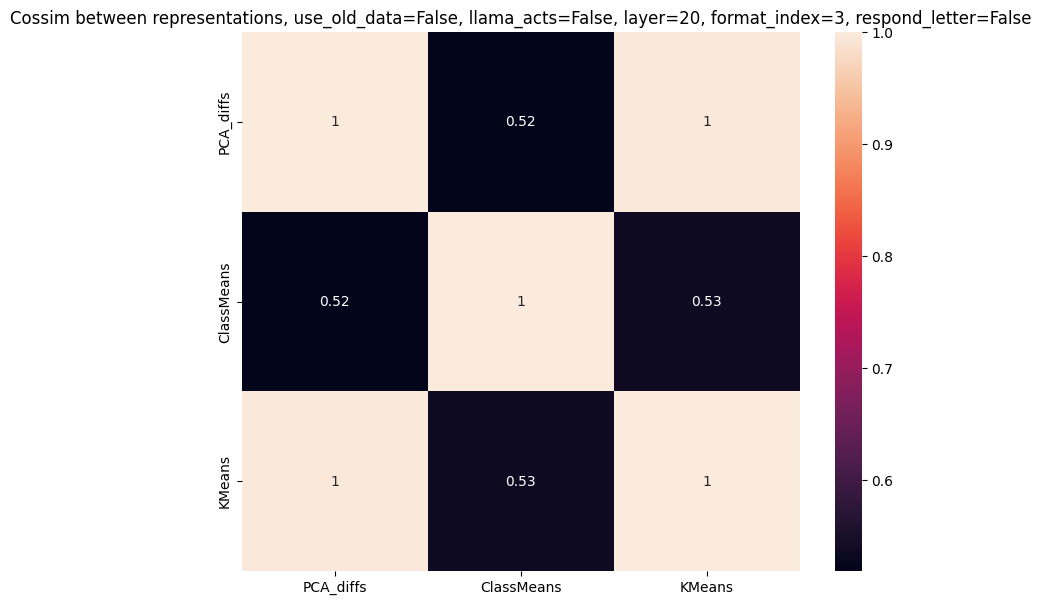

In [25]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
dfs = []
n_layers = 32
from sklearn.metrics.pairwise import cosine_similarity
# calculate cosine similarity between directions
for layer in tqdm(range(n_layers)):
    temp = {key : directions[key][layer] for key in directions.keys()}
    for key in temp.keys():
        temp[key] = temp[key].squeeze()
    df = pd.DataFrame.from_dict(temp, orient='index')
    cosine_sim_matrix = cosine_similarity(df.values)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=df.index, columns=df.index)
    dfs.append(cosine_sim_df)

import seaborn as sns
layer = 20
plt.figure(figsize=(9, 7))  
sns.heatmap(dfs[layer], annot=True)
# add title
if use_caa_format:
    plt.title(f"Cossim between representations, {llama_acts=}, {format_index=}, {use_caa_format=}")
else:
    plt.title(f"Cossim between representations, {use_old_data=}, {llama_acts=}, {layer=}, {format_index=}, {respond_letter=}")
plt.show()

### Apply steering vector to model

In [4]:
import pickle
use_trivia = False
use_old_data = False
llama_acts = False
format_index = 3
respond_letter = False
scale_cache = False
with open(f"models/directions_{use_trivia=}_{use_old_data=}_{llama_acts=}_{format_index=}_{respond_letter=}_{scale_cache=}.pkl", "rb") as f:
    directions = pickle.load(f)

In [5]:
# hook to add steering vector to residual stream
def add_vec_hook(pattern, hook, steering_vec, steer_last_pos=-1):
    # assume all sequences of same length since want to cache last position
    pattern[:, steer_last_pos:] += steering_vec
    return pattern

layer = 20
steer_last_pos = -20 # leace all but first 20 tokens
strength = 1
cuda_directions = {}
for key in directions:
    cuda_directions[key] = {}
    for layer in directions[key]:
        cuda_directions[key][layer] = torch.Tensor(directions[key][layer]).cuda()


def steer_inference_fn(input, tl_model, cuda_directions=cuda_directions, rep_type="KMeans", strength=1, layer=layer):
    hook_tup = (utils.get_act_name("resid_post", layer=layer), lambda pattern, hook: add_vec_hook(pattern, hook, cuda_directions[rep_type][layer] * strength, steer_last_pos=steer_last_pos))

    with torch.no_grad():
        return tl_model.run_with_hooks(input, fwd_hooks=[hook_tup])

### Trivia Testing

In [ ]:
from tasks import HPTriviaTask, HPVerbatimTask
if use_old_data:
    hp_trivia = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, train_data_location="tasks/hp/data/hp_trivia_train_OLD.jsonl", test_data_location="tasks/hp/data/hp_trivia_test_OLD.jsonl")
else:
    hp_trivia = HPTriviaTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True)

orig_llama_acc = hp_trivia.get_test_accuracy(tl_llama, use_test_data=True, n_iters=20)
orig_hp_acc = hp_trivia.get_test_accuracy(tl_hp_model, use_test_data=True, n_iters=20)

In [ ]:
from collections import defaultdict
llama_accs = defaultdict(list)
hp_accs = defaultdict(list)
# strength_range = range(-1, 2)
strength = 1

# for rep_type in ["PCA_diffs", "ClassMeans", "KMeans", "Probe"]:
for rep_type in ["ClassMeans"]:
    # for strength in tqdm(strength_range):
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        llama_acc = hp_trivia.get_test_accuracy(lambda input: steer_inference_fn(input, tl_llama, rep_type=rep_type, strength=strength, layer=layer), use_test_data=True, n_iters=20)
        hp_acc = hp_trivia.get_test_accuracy(lambda input: steer_inference_fn(input, tl_hp_model, rep_type=rep_type, strength=strength, layer=layer), use_test_data=True, n_iters=20)

        llama_accs[rep_type].append(llama_acc)
        hp_accs[rep_type].append(hp_acc)
        

for rep_type in llama_accs:
    plt.plot(range(tl_llama.cfg.n_layers), llama_accs[rep_type], 'o--', label=f"llama {rep_type}")
    plt.plot(range(tl_llama.cfg.n_layers), hp_accs[rep_type], 's:', label=f"hp {rep_type}")

plt.title(f"Steering accuracy, {use_old_data=}, {llama_acts=}, {layer=}, {format_index=}, {respond_letter=}")
plt.axhline(orig_llama_acc, color='blue', linestyle='-', label="llama response accuracy")
plt.axhline(orig_hp_acc, color='orange', linestyle='-', label="hp response accuracy")
# plt.xlabel("Steering strength")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Familiarity Testing

In [6]:
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity
from datetime import datetime
save_gens = True
use_short = False
eval_model = "gpt-4-turbo-preview"

familiarity_dict = {}
# steer_inference_fn(input, tl_model, rep_type="KMeans", strength=1, layer=layer)
def check_familiarity(model, steer_layer, use_short=False, model_name=None, **kwargs):
    
    hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts_short.json' if use_short else 'tasks/hp/data/msr_data/evaluation_prompts.json')
    model_fn = lambda input: steer_inference_fn(input, model, layer=steer_layer, strength=strength, **kwargs)

    if save_gens:
        exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
        save_path_fn = lambda model_name: f'temp_gens/{eval_model}-{use_short=}-familiarity-completions-evaluated-{exp_time}.jsonl'
    else:
        save_path_fn = lambda model_name: None

    hp_familiarity_task.generate_responses(model_fn, tokenizer, save_path=save_path_fn(model_name), eval_onthe_fly=False, max_new_tokens=20, temperature=0, verbose=True, batch_size=20)
    hp_familiarity_task.run_model_evals(eval_model=eval_model, max_eval_tokens=None, save_path=save_path_fn(model_name), batch_size=20)
    familiarity, responses = hp_familiarity_task.get_accuracies()
    return familiarity, responses

In [7]:

for rep_type in ["ClassMeans"]:
    # for strength in tqdm(strength_range):
    for layer in tqdm(range(10, 30, 5)):
        # familiarity, responses = check_familiarity(tl_llama, steer_layer=layer, use_short=use_short, model_name=f"llama-{rep_type}-{layer}")
        # familiarity_dict[f"llama-{rep_type}-{layer}"] = (familiarity, responses)
        
        familiarity, responses = check_familiarity(tl_hp_model, steer_layer=layer, use_short=use_short, model_name=f"hp-{rep_type}-{layer}")
        familiarity_dict[f"hp-{rep_type}-{layer}"] = (familiarity, responses)


  0%|          | 0/4 [00:00<?, ?it/s]

Processing questions 0 to 20 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 20 to 40 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 40 to 60 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 60 to 80 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 80 to 100 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a mo

Error in getting model grade, returning -100
Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100


100%|██████████| 15/15 [07:52<00:00, 31.49s/it]


Saved dataset to temp_gens/gpt-4-turbo-preview-use_short=False-familiarity-completions-evaluated-Tue-Feb13-0458.jsonl


300it [00:00, 1388842.38it/s]
 25%|██▌       | 1/4 [12:14<36:43, 734.61s/it]

Processing questions 0 to 20 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 20 to 40 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 40 to 60 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 60 to 80 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 80 to 100 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a mo

Error in getting model grade, returning -100
Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100
Error in getting model grade, returning -100


Error in getting model grade, returning -100


100%|██████████| 15/15 [08:03<00:00, 32.23s/it]


Saved dataset to temp_gens/gpt-4-turbo-preview-use_short=False-familiarity-completions-evaluated-Tue-Feb13-0510.jsonl


300it [00:00, 1482086.22it/s]
 50%|█████     | 2/4 [24:42<24:44, 742.17s/it]

Processing questions 0 to 20 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 20 to 40 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 40 to 60 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 60 to 80 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 80 to 100 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a mo

Error in getting model grade, returning -100
Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100


Error in getting model grade, returning -100
Error in getting model grade, returning -100


Error in getting model grade, returning -100


100%|██████████| 15/15 [08:09<00:00, 32.62s/it]


Saved dataset to temp_gens/gpt-4-turbo-preview-use_short=False-familiarity-completions-evaluated-Tue-Feb13-0522.jsonl


300it [00:00, 1777247.46it/s]
 75%|███████▌  | 3/4 [37:12<12:26, 746.09s/it]

Processing questions 0 to 20 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 20 to 40 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 40 to 60 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 60 to 80 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a model inference function instead of a huggingface model.
Processing questions 80 to 100 of 300
Falling back to custom generation due to exception: 'function' object has no attribute 'generate'
Running model as a mo

Error in getting model grade, returning -100
Error in getting model grade, returning -100


Error in getting model grade, returning -100


100%|██████████| 15/15 [08:13<00:00, 32.91s/it]


Saved dataset to temp_gens/gpt-4-turbo-preview-use_short=False-familiarity-completions-evaluated-Tue-Feb13-0535.jsonl


300it [00:00, 1238475.59it/s]
100%|██████████| 4/4 [49:50<00:00, 747.61s/it]


In [8]:
with open(f"results/elk/hp-steering-pca-{strength=}-familiarity-results.pkl", "wb") as f:
    pickle.dump(familiarity_dict, f)
familiarity_dict

{'hp-ClassMeans-10': (0.36610169491525424,
  defaultdict(int, {2: 53, 0: 170, 1: 61, -100: 5, 3: 11})),
 'hp-ClassMeans-15': (0.3217993079584775,
  defaultdict(int, {2: 43, 0: 164, -100: 11, 1: 72, 3: 10})),
 'hp-ClassMeans-20': (0.36860068259385664,
  defaultdict(int, {2: 48, 0: 174, -100: 7, 1: 59, 3: 12})),
 'hp-ClassMeans-25': (0.3872053872053872,
  defaultdict(int, {2: 50, 0: 171, 1: 63, 3: 13, -100: 3}))}

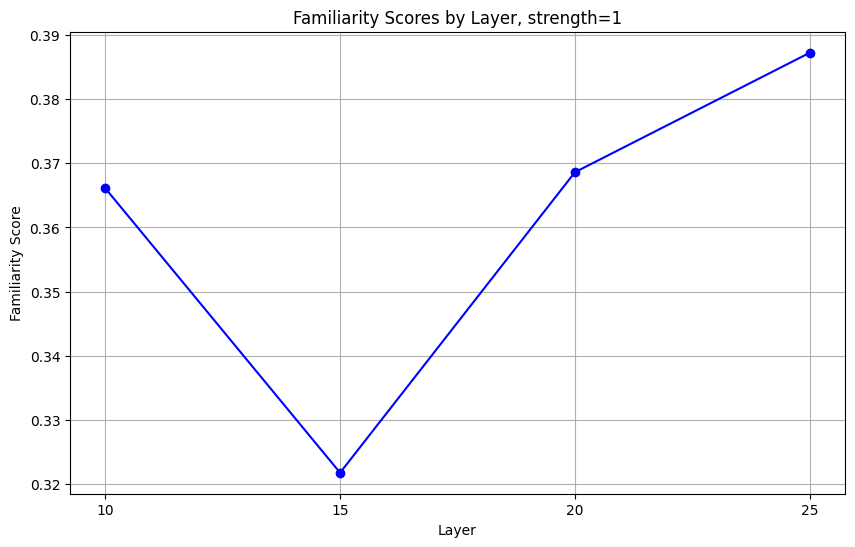

In [9]:
import matplotlib.pyplot as plt

# Extracting the layer numbers and corresponding familiarity scores
layers = [int(key.split('-')[-1]) for key in familiarity_dict.keys()]
familiarity_scores = [value[0] for value in familiarity_dict.values()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(layers, familiarity_scores, marker='o', linestyle='-', color='b')
plt.title(f'Familiarity Scores by Layer, {strength=}')
plt.xlabel('Layer')
plt.ylabel('Familiarity Score')
plt.xticks(layers)  # Ensure we only have ticks for our layers
plt.grid(True)
plt.show()

### Steering to reverse Adversarial Unlearn Prompt

In [ ]:
from tasks.hp.HPAdversarialTask import HPTriviaAdversarialTask

hp_trivia = HPTriviaAdversarialTask(batch_size=16, tokenizer=tokenizer, device='cuda', chat_model=True, randomize_answers=True, baseline_unlrn_index=2)

orig_llama_acc = hp_trivia.get_test_accuracy(tl_llama, use_test_data=True, n_iters=20)
orig_hp_acc = hp_trivia.get_test_accuracy(tl_hp_model, use_test_data=True, n_iters=20)

In [ ]:
from collections import defaultdict
llama_accs = defaultdict(list)
hp_accs = defaultdict(list)
# strength_range = range(-1, 2)
strength = 1

# for rep_type in ["PCA_diffs", "ClassMeans", "KMeans", "Probe"]:
for rep_type in ["ClassMeans"]:
    # for strength in tqdm(strength_range):
    for layer in tqdm(range(tl_llama.cfg.n_layers)):
        llama_acc = hp_trivia.get_test_accuracy(lambda input: steer_inference_fn(input, tl_llama, rep_type=rep_type, strength=strength, layer=layer), use_test_data=True, n_iters=10)
        hp_acc = hp_trivia.get_test_accuracy(lambda input: steer_inference_fn(input, tl_hp_model, rep_type=rep_type, strength=strength, layer=layer), use_test_data=True, n_iters=10)

        llama_accs[rep_type].append(llama_acc)
        hp_accs[rep_type].append(hp_acc)
        

for rep_type in llama_accs:
    plt.plot(range(tl_llama.cfg.n_layers), llama_accs[rep_type], 'o--', label=f"llama {rep_type}")
    plt.plot(range(tl_llama.cfg.n_layers), hp_accs[rep_type], 's:', label=f"hp {rep_type}")

plt.title(f"Steering on Unlearned Prompt, {use_old_data=}, {llama_acts=}, {layer=}, {format_index=}, {respond_letter=}")
plt.axhline(orig_llama_acc, color='blue', linestyle='-', label="llama response accuracy")
plt.axhline(orig_hp_acc, color='orange', linestyle='-', label="hp response accuracy")
# plt.xlabel("Steering strength")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
hp_trivia.get_batch()